### Problem Statement:- 
** A bank wants to target customers with a loan product. The objective is to build a ML model to predict the likelyhood of customers buying the loan product which will help the bank is spending less on the marketing campaign and getting maximum returns. **

### Load libraries

In [1]:
import pandas as pd
import os
from datetime import datetime
import numpy as np
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_curve, auc, average_precision_score
from sklearn.preprocessing import binarize
from keras.models import model_from_json
from keras.optimizers import SGD, Adam, rmsprop
import seaborn as sns
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import rcParams, colors
rcParams['figure.figsize'] = 15,7


%matplotlib inline
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns',50)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

C:\Users\akxay\Anaconda\envs\deeplearning\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\akxay\Anaconda\envs\deeplearning\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


height has been deprecated.



### Load training and test data

In [169]:
# ()
dirPath = r'../data'
os.chdir(dirPath)
data = pd.read_csv('DEV_SAMPLE.csv')
test = pd.read_csv('HOLDOUT_SAMPLE.csv')
print('Training data size is {}, test data size is {}'.format(data.shape, test.shape))

Training data size is (14000, 10), test data size is (6000, 10)


In [99]:
data.head()

,Cust_ID,Target,Age,Gender,Balance,Occupation,No_OF_CR_TXNS,AGE_BKT,SCR,Holding_Period
0,C16505,0,41,M,91519.920,SELF-EMP,38,41-45,926,15
1,C17241,0,52,M,117288.960,SAL,17,>50,768,13
2,C18802,0,31,F,259827.440,SENP,8,31-35,816,5
3,C19289,0,45,F,26677.550,PROF,14,41-45,353,18
4,C14028,0,39,F,43440.310,SENP,1,36-40,751,31


In [100]:
data.describe()

,Target,Age,Balance,No_OF_CR_TXNS,SCR,Holding_Period
count,14000.000,14000.000,14000.000,14000.000,14000.000,14000.000
mean,0.088,38.467,144987.259,16.796,556.279,15.271
std,0.284,9.537,169261.436,13.018,261.464,8.967
min,0.000,21.000,0.000,0.000,100.000,1.000
25%,0.000,30.000,23729.430,7.000,330.000,7.000
50%,0.000,38.000,79059.200,14.000,559.000,16.000
75%,0.000,46.250,213224.952,22.000,785.250,23.000
max,1.000,55.000,1246966.770,50.000,999.000,31.000


In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 10 columns):
Cust_ID           14000 non-null object
Target            14000 non-null int64
Age               14000 non-null int64
Gender            14000 non-null object
Balance           14000 non-null float64
Occupation        14000 non-null object
No_OF_CR_TXNS     14000 non-null int64
AGE_BKT           14000 non-null object
SCR               14000 non-null int64
Holding_Period    14000 non-null int64
dtypes: float64(1), int64(5), object(4)
memory usage: 1.1+ MB


In [102]:
## checking for nulls
print ('Number of null in the training set :\n', pd.isnull(data).sum())
print ('Number of null in the validation set :\n', pd.isnull(test).sum())

Number of null in the training set :
 Cust_ID           0
Target            0
Age               0
Gender            0
Balance           0
Occupation        0
No_OF_CR_TXNS     0
AGE_BKT           0
SCR               0
Holding_Period    0
dtype: int64
Number of null in the validation set :
 Cust_ID           0
Target            0
Age               0
Gender            0
Balance           0
Occupation        0
No_OF_CR_TXNS     0
AGE_BKT           0
SCR               0
Holding_Period    0
dtype: int64


In [103]:
# Unique Value counts in cat variables
cat_df = data.select_dtypes(include=['object'])
for col in list(cat_df.columns):
    print (str(col) + '----    ' + str(len(cat_df[col].unique())) )

Cust_ID----    14000
Gender----    3
Occupation----    4
AGE_BKT----    7


### EDA

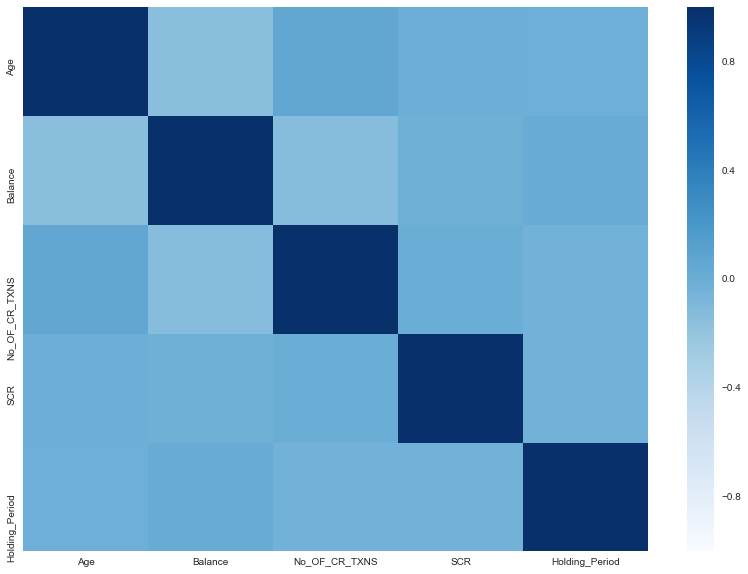

In [104]:
fig = plt.figure(figsize=(14,10))
# sns.set(font_scale=1.2)
numerical_feature=data.dtypes[data.dtypes!= 'object'].drop(['Target']).index
corr = data[numerical_feature].corr()
sns.heatmap(corr, cmap='Blues')

### Data Pre-processing and Feature Engineering

In [105]:
# age_bkt_values_num = {'<25': 0, '26-30':1, '31-35': 2, '36-40': 3, '41-45': 4, '46-50': 5, '>50': 6}
# data['AGE_BKT_num'] = data.AGE_BKT
# data = data.replace({'AGE_BKT_num': age_bkt_values_num})
data.head()

,Cust_ID,Target,Age,Gender,Balance,Occupation,No_OF_CR_TXNS,AGE_BKT,SCR,Holding_Period
0,C16505,0,41,M,91519.920,SELF-EMP,38,41-45,926,15
1,C17241,0,52,M,117288.960,SAL,17,>50,768,13
2,C18802,0,31,F,259827.440,SENP,8,31-35,816,5
3,C19289,0,45,F,26677.550,PROF,14,41-45,353,18
4,C14028,0,39,F,43440.310,SENP,1,36-40,751,31


In [109]:
features = ['Cust_ID', 'Age','Gender','Balance','Occupation', 'No_OF_CR_TXNS', 'AGE_BKT', 'SCR','Holding_Period' ]

In [110]:
x_train, x_val, y_train, y_val = train_test_split(data[features], data.Target, test_size=0.3, random_state=111)
print('train feature space is {}, validation feature space is {}'.format(x_train.shape, x_val.shape))

train feature space is (9800, 9), validation feature space is (4200, 9)


### Target Variable Distribution

0   0.912
1   0.088
Name: Target, dtype: float64


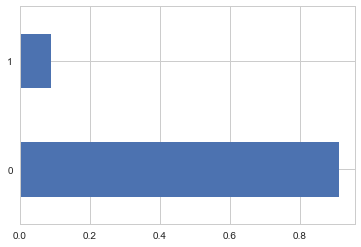

In [111]:
valueCounts = data.Target.value_counts() / len(data)
print (valueCounts)
valueCounts.plot.barh()

In [112]:
train_valueCounts = y_train.value_counts() / len(y_train)
print (train_valueCounts)

0   0.911
1   0.089
Name: Target, dtype: float64


In [113]:
val_valueCounts = y_val.value_counts() / len(y_val)
print (val_valueCounts)

0   0.914
1   0.086
Name: Target, dtype: float64


### Encoding Categorical variables- Label or dummy

In [114]:
# dummy encode
x_train_dummy = pd.get_dummies(x_train.iloc[:,1:], dummy_na=False)
x_val_dummy = pd.get_dummies(x_val.iloc[:,1:], dummy_na=False)

# ------------------------------OR------------------------------------------------

# label Encode
gender_values = {'F':0,'M':1,'O':2}
occupation_values = {'PROF':0,'SAL':1,'SELF-EMP':2,'SENP':3}
age_bkt_values = {'<25':0, '26-30':1, '31-35':2, '36-40':3, '41-45':4, '46-50':5, '>50':6,}
x_train = x_train.replace({'Gender':gender_values, 'Occupation': occupation_values, 'AGE_BKT':age_bkt_values})
x_val = x_val.replace({'Gender':gender_values, 'Occupation': occupation_values, 'AGE_BKT':age_bkt_values})

### Model Evaluation Metrics 

In [115]:
def plot_roc(fpr, tpr, roc_auc):
    print(roc_auc)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %1.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def model_result(model, feature, label, thres):
    model_metrics = dict()

    predict_prob = model.predict_proba(feature)[:, 1]
    predicted = binarize([predict_prob], thres)[0]
    
    # predicted = model.predict(feature)
    print(confusion_matrix(label, predicted))
    tn, fp, fn, tp = confusion_matrix(label, predicted).ravel()
    true_positive_rate = recall_score(label, predicted)
    false_positive_rate = fp/float(tn+fp)
    precision = precision_score(label, predicted)
    f_score = f1_score(label, predicted)
    fpr, tpr, thresholds = roc_curve(label, predict_prob)    
    roc_auc = auc(fpr, tpr)
    
    model_metrics['true_positive_rate'] = float(true_positive_rate)
    model_metrics['false_positive_rate'] = float(false_positive_rate)
    model_metrics['confusion_matrix'] = {'true_positive':int(tp), 'true_negative':int(tn), 'false_positive':int(fp), 'false_negative':int(fn)}
    model_metrics['precision'] = float(precision)
    model_metrics['recall'] = float(true_positive_rate)
    model_metrics['f_score'] = float(f_score)
    model_metrics['roc_auc'] = roc_auc
    plot_roc(fpr, tpr, roc_auc) 
    return model_metrics


### visualize how well our model is separating the classes

In [116]:
def _plot_prob_dist(model, feature, label):
    predict_prob = model.predict_proba(feature)[:, 1]
    df = pd.DataFrame(predict_prob, columns=["predicted_prob"])    
    df['actual_class'] = label

    fig = plt.figure()
    ax_hist = fig.add_subplot(212)
    ax_hist.set_ylabel("Prob Distribution")
    ax_hist.hist(
        [   df[df['actual_class'] == 1]['predicted_prob'],
            df[df['actual_class'] == 0]['predicted_prob']],
        stacked = True,
        rwidth = 1,
        label = ["No", "Yes"],
        color = ["g", "b"],
        alpha = 0.8)

### Decision Tree

In [117]:
from sklearn.tree import DecisionTreeClassifier
min_samples_leaf = int(1*(x_train.shape[0])/100)
min_samples_split = 2*min_samples_leaf
criterion='gini'
dtree=DecisionTreeClassifier(criterion=criterion, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, 
                             random_state=0)

dtree.fit(x_train_dummy,y_train)
train_prob = dtree.predict_proba(x_train_dummy)
val_prob = dtree.predict_proba(x_val_dummy)

# dtree.fit(x_train.iloc[:,1:],y_train)
# train_prob = dtree.predict_proba(x_train.iloc[:,1:])
# val_prob = dtree.predict_proba(x_val.iloc[:,1:])

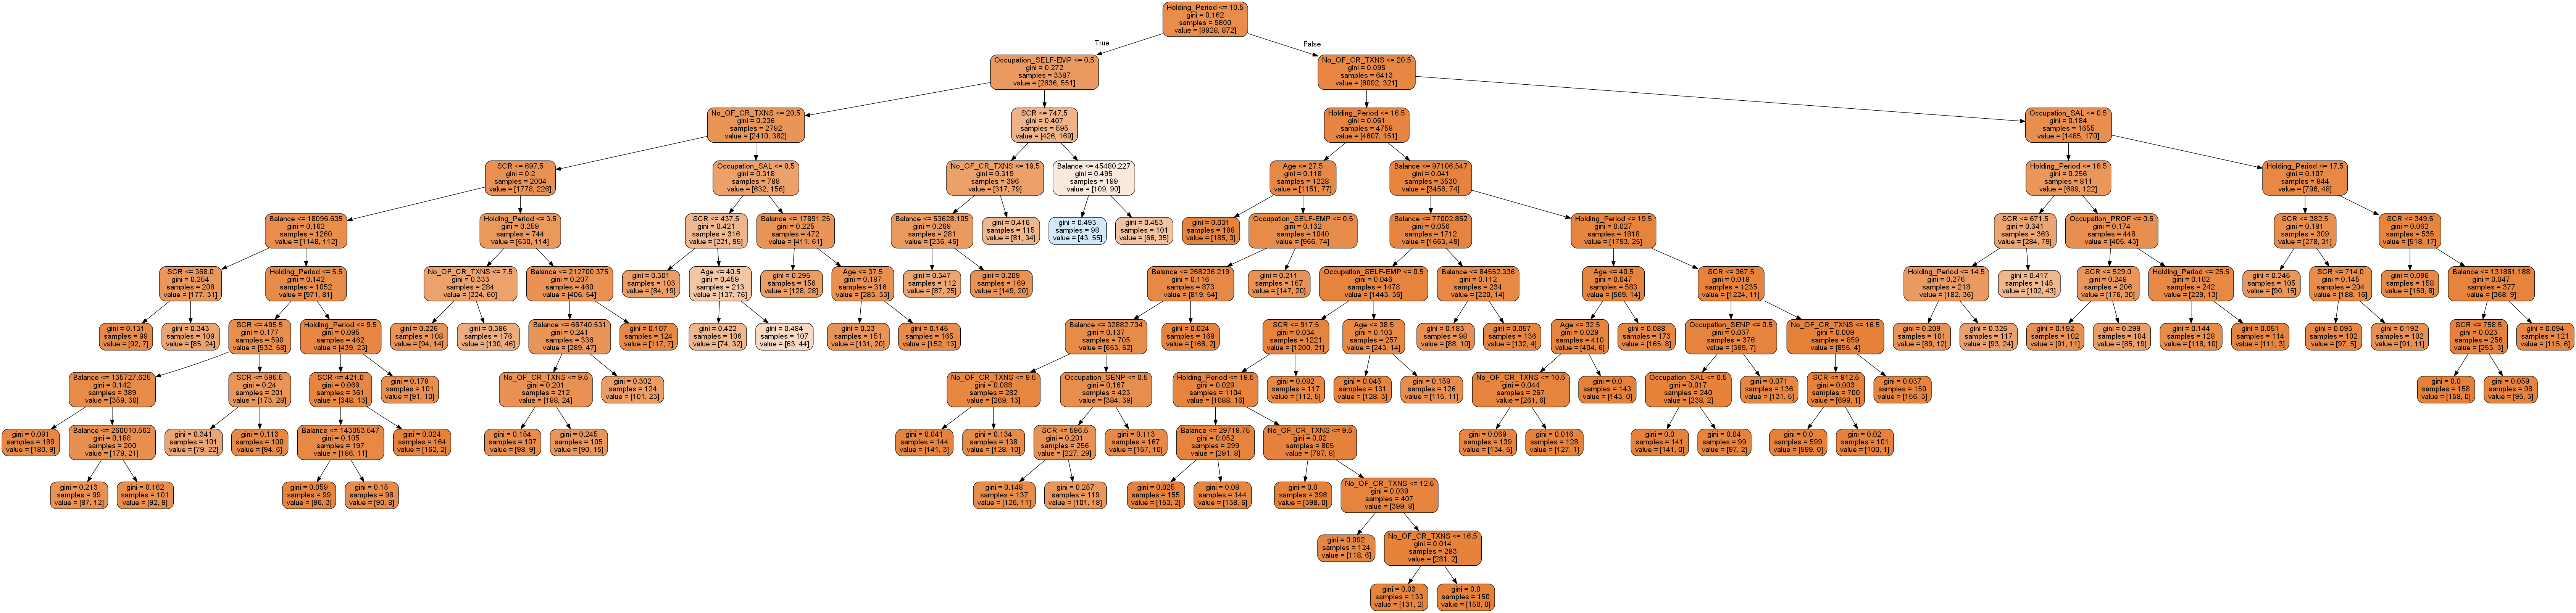

In [118]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=False, feature_names = x_train_dummy.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
''' dot_data.getvalue() - to get tree structure'''
Image(graph.create_png())

# Double click on chart to zoom-in/zoom-out

### Random Forest

In [119]:
from sklearn.ensemble import RandomForestClassifier
min_samples_leaf = int(1*(x_train.shape[0])/100)
min_samples_split = 2*min_samples_leaf
rf = RandomForestClassifier(n_jobs=-1,max_features=4,oob_score=True, 
                                     n_estimators=200,min_samples_leaf=50,min_samples_split=150,random_state=0)
# rf.fit(x_train_dummy, y_train)
rf.fit(x_train.iloc[:,1:], y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=150,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

[[8383  545]
 [ 532  340]]
0.8347582135164907


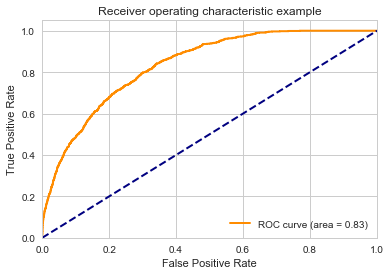

{'confusion_matrix': {'false_negative': 532,
  'false_positive': 545,
  'true_negative': 8383,
  'true_positive': 340},
 'f_score': 0.3870233352305066,
 'false_positive_rate': 0.06104390681003584,
 'precision': 0.384180790960452,
 'recall': 0.38990825688073394,
 'roc_auc': 0.8347582135164907,
 'true_positive_rate': 0.38990825688073394}

In [120]:
model_result(rf, x_train.iloc[:,1:], y_train, 0.2)

[[3620  217]
 [ 233  130]]
0.7914481369240058


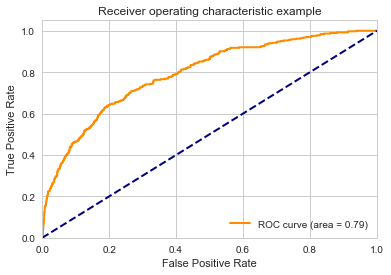

{'confusion_matrix': {'false_negative': 233,
  'false_positive': 217,
  'true_negative': 3620,
  'true_positive': 130},
 'f_score': 0.3661971830985916,
 'false_positive_rate': 0.05655459994787594,
 'precision': 0.3746397694524496,
 'recall': 0.3581267217630854,
 'roc_auc': 0.7914481369240058,
 'true_positive_rate': 0.3581267217630854}

In [121]:
model_result(rf, x_val.iloc[:,1:], y_val, 0.2)

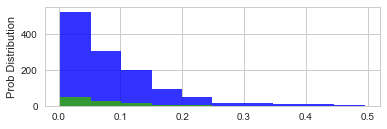

In [122]:
_plot_prob_dist(rf, x_val.iloc[:,1:], y_val)

### As our data is highly imbalanced, let's try Over-sampling and Undersampling techniques

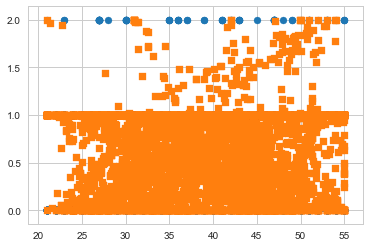

In [123]:
smt = SMOTETomek(ratio='auto')
# smt = SMOTE(ratio='minority')
X_smt, y_smt = smt.fit_sample(x_train.iloc[:,1:], y_train)
colors = ['#1F77B4', '#FF7F0E']
markers = ['o', 's']
for l, c, m in zip(np.unique(y_smt), colors, markers):
        plt.scatter(
            X_smt[y_smt==l, 0],
            X_smt[y_smt==l, 1],
            c=c, label=l, marker=m
        )

In [124]:
X_smt.shape, y_smt.shape

((16214, 8), (16214,))

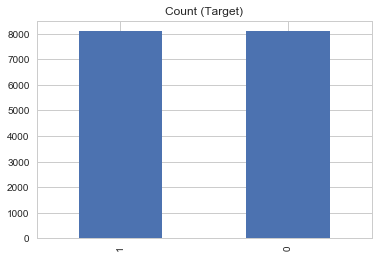

In [125]:
pd.DataFrame(y_smt)[0].value_counts().plot(kind='bar', title='Count (Target)');

In [126]:
from sklearn.ensemble import RandomForestClassifier
min_samples_leaf = int(1*(x_train.shape[0])/100)
min_samples_split = 2*min_samples_leaf
smote_rf = RandomForestClassifier(n_jobs=-1,max_features=4,oob_score=True, 
                                     n_estimators=500,min_samples_leaf=100,min_samples_split=300,random_state=0)

# smoted data
smote_rf.fit(X_smt, y_smt)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=300,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

[[6674 1433]
 [ 886 7221]]
0.9439537858093845


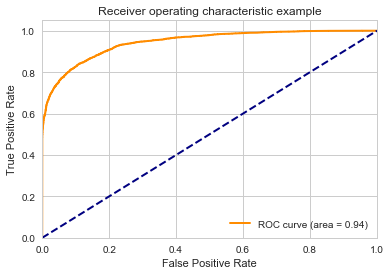

{'confusion_matrix': {'false_negative': 886,
  'false_positive': 1433,
  'true_negative': 6674,
  'true_positive': 7221},
 'f_score': 0.8616431000536962,
 'false_positive_rate': 0.17676082397927717,
 'precision': 0.8344118326785301,
 'recall': 0.8907117306031824,
 'roc_auc': 0.9439537858093845,
 'true_positive_rate': 0.8907117306031824}

In [127]:
model_result(smote_rf, X_smt, y_smt, 0.4)

[[3199  638]
 [ 156  207]]
0.7856057195740187


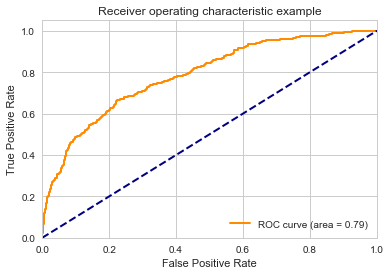

{'confusion_matrix': {'false_negative': 156,
  'false_positive': 638,
  'true_negative': 3199,
  'true_positive': 207},
 'f_score': 0.3427152317880795,
 'false_positive_rate': 0.16627573625228043,
 'precision': 0.24497041420118343,
 'recall': 0.5702479338842975,
 'roc_auc': 0.7856057195740187,
 'true_positive_rate': 0.5702479338842975}

In [128]:
model_result(smote_rf, x_val.iloc[:,1:], y_val, 0.4)

With SMote, we do not get much improvement in AUC on test set but clearly from marketing stand point, we can get high 
true postive Rate which is a good customer base who is more likely to respond to our campaign.
All this makes sense because cost of targeting is very less but profit will be more considering the customer responds

###  Building a Neural Network using Keras and tensorflow as backend

In [129]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [130]:
scaler = StandardScaler()
# x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train.iloc[:,1:]))
# x_val_scaled = pd.DataFrame(scaler.transform(x_val.iloc[:,1:]))

x_train_scaled = pd.DataFrame(scaler.fit_transform(X_smt))
x_val_scaled = pd.DataFrame(scaler.transform(x_val.iloc[:,1:]))

In [135]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
def create_nn_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=x_train.iloc[:,1:].shape[1], activation='sigmoid', kernel_initializer='normal'))
    model.add(Dense(4, activation='sigmoid', kernel_initializer='normal'))  
    model.add(Dense(2, activation='sigmoid'))
#     adam = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

In [136]:
import keras
new_y_train = keras.utils.to_categorical(y_smt, num_classes=None)
new_y_val = keras.utils.to_categorical(y_val, num_classes=None)

In [137]:
# # cross validation results
# x_train_nn = x_train.append(x_val)
# y_train_nn = y_train.append(y_val)
# # class_weight = {0: 5.,
# #                 1: 1.}
# np.random.seed(seed)
# estimators = []
# estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasClassifier(build_fn=create_nn_model, epochs=20, batch_size=32, verbose=1)))
# pipeline = Pipeline(estimators)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
# results = cross_val_score(pipeline, x_train_nn.iloc[:,1:], y_train_nn, cv=kfold)
# print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [138]:
nn_model = create_nn_model()
nn_model.fit(
 x_train_scaled, new_y_train,
 epochs= 20,
 batch_size = 16,
 validation_data = (x_val_scaled, new_y_val)
)

Train on 16214 samples, validate on 4200 samples
Epoch 1/20
16214/16214 [==============================] - 4s 222us/step - loss: 0.6955 - acc: 0.4998 - val_loss: 0.6939 - val_acc: 0.5000
Epoch 2/20
16214/16214 [==============================] - 3s 187us/step - loss: 0.6932 - acc: 0.5008 - val_loss: 0.6967 - val_acc: 0.0864
Epoch 3/20
16214/16214 [==============================] - 3s 196us/step - loss: 0.6931 - acc: 0.5051 - val_loss: 0.6878 - val_acc: 0.9136
Epoch 4/20
16214/16214 [==============================] - 3s 183us/step - loss: 0.6930 - acc: 0.5081 - val_loss: 0.6957 - val_acc: 0.0893
Epoch 5/20
16214/16214 [==============================] - 3s 196us/step - loss: 0.6929 - acc: 0.5270 - val_loss: 0.6933 - val_acc: 0.3952
Epoch 6/20
16214/16214 [==============================] - 3s 203us/step - loss: 0.6928 - acc: 0.5267 - val_loss: 0.6872 - val_acc: 0.9136
Epoch 7/20
16214/16214 [==============================] - 3s 192us/step - loss: 0.6927 - acc: 0.5267 - val_loss: 0.6913 - v

### Hyper-parameter tuning using grid Search

We can tune all the hyper-parameters using grid-Search, but because of lack of time and computation power, not performing this step

In [39]:
# # define the grid search parameters
# from sklearn.model_selection import GridSearchCV
# batch_size = [10, 20, 40, 60, 80, 100]
# epochs = [10, 50, 100]
# param_grid = dict(batch_size=batch_size, epochs=epochs)
# grid = GridSearchCV(estimator=create_nn_model(), param_grid=param_grid, n_jobs=-1)
# grid_result = grid.fit(x_train_nn.iloc[:,1:], y_train_nn)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

[[2746 1091]
 [ 128  235]]
0.7512487157451263


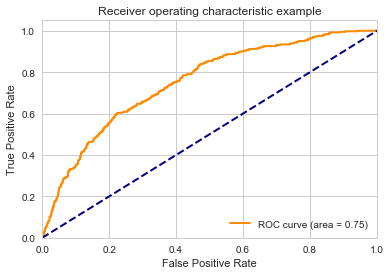

{'confusion_matrix': {'false_negative': 128,
  'false_positive': 1091,
  'true_negative': 2746,
  'true_positive': 235},
 'f_score': 0.27827116637063354,
 'false_positive_rate': 0.2843367213969247,
 'precision': 0.17722473604826547,
 'recall': 0.6473829201101928,
 'roc_auc': 0.7512487157451263,
 'true_positive_rate': 0.6473829201101928}

In [139]:
model_result(nn_model, x_val_scaled,  y_val, 0.5)

### Saving NN model

In [162]:
# # # serialize model to JSON
# # serialize model to JSON
model_json = nn_model.to_json()
with open('../model/dnn_model.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
nn_model.save_weights("../model/dnn_model_weights.h5")
print("Saved model to disk")

# from sklearn.externals import joblib 
joblib.dump(scaler, '../model/scaler_model.pkl')

Saved model to disk


['../model/scaler_model.pkl']

### Load Model

In [167]:
# # # load json and create model
json_file = open('../model/dnn_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("../model/dnn_model_weights.h5")
print("Loaded model from disk")
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Loaded model from disk


### Evaluate on test data

In [170]:
# age_bkt_values_num = {'<25': 0, '26-30':1, '31-35': 2, '36-40': 3, '41-45': 4, '46-50': 5, '>50': 6}
# test['AGE_BKT_num'] = test.AGE_BKT
# test = test.replace({'AGE_BKT_num': age_bkt_values_num})

y_test = test.Target
test = test.drop(['Target', 'Cust_ID'], axis=1)
x_test = test.replace({'Gender':gender_values, 'Occupation': occupation_values, 'AGE_BKT':age_bkt_values})
x_test.head()

,Age,Gender,Balance,Occupation,No_OF_CR_TXNS,AGE_BKT,SCR,Holding_Period
0,26,1,67291.630,3,6,1,559,31
1,31,1,151255.630,0,8,2,652,24
2,26,1,67814.450,1,35,1,531,9
3,23,1,370783.970,1,5,0,434,11
4,40,0,284187.580,3,3,3,679,8


** Evaluation using Random Forest **

[[4712  790]
 [ 260  238]]
0.7712518558421253


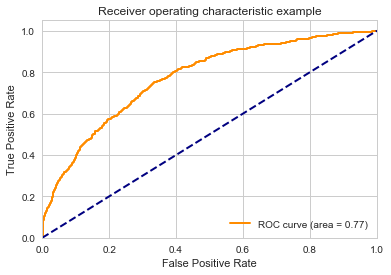

{'confusion_matrix': {'false_negative': 260,
  'false_positive': 790,
  'true_negative': 4712,
  'true_positive': 238},
 'f_score': 0.3119266055045872,
 'false_positive_rate': 0.14358415121773901,
 'precision': 0.23151750972762647,
 'recall': 0.4779116465863454,
 'roc_auc': 0.7712518558421253,
 'true_positive_rate': 0.4779116465863454}

In [141]:
model_result(rf, x_test, y_test, 0.15)

** Evaluation using Smote and Random Forest **

[[4524  978]
 [ 251  247]]
0.7530624132298004


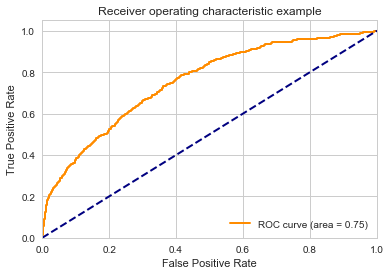

{'confusion_matrix': {'false_negative': 251,
  'false_positive': 978,
  'true_negative': 4524,
  'true_positive': 247},
 'f_score': 0.2867092280905397,
 'false_positive_rate': 0.1777535441657579,
 'precision': 0.2016326530612245,
 'recall': 0.4959839357429719,
 'roc_auc': 0.7530624132298004,
 'true_positive_rate': 0.4959839357429719}

In [142]:
model_result(smote_rf, x_test, y_test, 0.4)

In [164]:
# # Saving Random Forest
# # save the model to disk
import pickle
filename = '../model/Random_forest_model.pkl'
pickle.dump(smote_rf, open(filename, 'wb'))

In [165]:
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=300,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

** Evaluation using and Neural Network **

In [168]:
# # evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
# score = loaded_model.evaluate(x_test, y_test, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [171]:
from sklearn.externals import joblib
x_test = joblib.load('../model/scaler_model.pkl').transform(x_test)

[[3979 1523]
 [ 179  319]]
0.7402587449032773


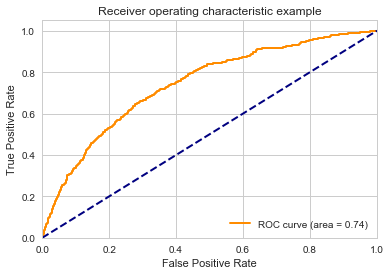

{'confusion_matrix': {'false_negative': 179,
  'false_positive': 1523,
  'true_negative': 3979,
  'true_positive': 319},
 'f_score': 0.2726495726495726,
 'false_positive_rate': 0.2768084332969829,
 'precision': 0.1731813246471227,
 'recall': 0.6405622489959839,
 'roc_auc': 0.7402587449032773,
 'true_positive_rate': 0.6405622489959839}

In [175]:
model_result(nn_model, x_test, y_test, 0.5)